# Importing & Loading Data

In [921]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import class_weight


In [922]:
df = pd.read_csv('https://raw.githubusercontent.com/ardahk/amex/main/data/final_data.csv')

# Data Preparation

In [923]:
# Taking a peak
df.head()

,order_id,user_id,gender,num_of_item,id_orders,product_id,order_created_at,status_cancelled,status_complete,status_processing,...,retail_price,department,id_events,sequence_number,created_at,state_events,postal_code_events,browser,traffic_source_events,event_type
0,112736,90067,F,2,163681,9588,2022-11-27 13:28:30+00:00,0,0,1,...,36.000000,Women,1176673,7,2022-11-27 13:28:30+00:00,South Carolina,29588,Firefox,Adwords,purchase
1,185,149,F,2,279,1238,2021-08-30 08:34:34+00:00,1,0,0,...,31.920000,Women,2113,7,2021-08-30 08:34:34+00:00,Florida,33317,Chrome,Organic,purchase
2,185,149,F,2,278,5485,2021-09-02 10:08:47+00:00,1,0,0,...,34.990002,Women,2106,7,2021-09-02 10:08:47+00:00,Florida,33317,IE,Email,purchase
3,59511,47530,F,3,86530,5485,2022-10-18 08:58:43+00:00,0,1,0,...,34.990002,Women,622843,10,2022-10-18 08:58:43+00:00,New York,13021,Chrome,Email,purchase
4,33505,26850,F,2,48710,5485,2023-03-25 13:52:09+00:00,0,0,0,...,34.990002,Women,350593,7,2023-03-25 13:52:09+00:00,Massachusetts,1701,Chrome,Facebook,purchase


In [924]:
# Full list of columns
list(df.columns)

['order_id',
 'user_id',
 'gender',
 'num_of_item',
 'id_orders',
 'product_id',
 'order_created_at',
 'status_cancelled',
 'status_complete',
 'status_processing',
 'status_returned',
 'status__shipped',
 'age',
 'state_orders',
 'postal_code_orders',
 'traffic_source_orders',
 'cost',
 'category',
 'name',
 'brand',
 'retail_price',
 'department',
 'id_events',
 'sequence_number',
 'created_at',
 'state_events',
 'postal_code_events',
 'browser',
 'traffic_source_events',
 'event_type']

### Dropping Unwanted Columns

In [925]:
# How many unique values are there for these Features
df[['department','name','gender','traffic_source_orders', 'category', 'brand']].nunique()

,0
department,2
name,13503
gender,2
traffic_source_orders,5
category,26
brand,2088


In [926]:
# Dropping unwanted columns
dropped_columns = [
    'order_id',
    'event_type',
    'state_events',
    'created_at',
    'order_created_at',
    'status__shipped',
    'status_processing',
    'name',
    'department',
    'sequence_number',
    'id_orders',
    'browser',
    'traffic_source_events',
    'id_events'
]
df.drop(columns=dropped_columns, inplace=True)

In [927]:
# Full list of columns after dropped
list(df.columns)

['user_id',
 'gender',
 'num_of_item',
 'product_id',
 'status_cancelled',
 'status_complete',
 'status_returned',
 'age',
 'state_orders',
 'postal_code_orders',
 'traffic_source_orders',
 'cost',
 'category',
 'brand',
 'retail_price',
 'postal_code_events']

In [928]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19696 entries, 0 to 19695
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                19696 non-null  int64  
 1   gender                 19696 non-null  object 
 2   num_of_item            19696 non-null  int64  
 3   product_id             19696 non-null  int64  
 4   status_cancelled       19696 non-null  int64  
 5   status_complete        19696 non-null  int64  
 6   status_returned        19696 non-null  int64  
 7   age                    19696 non-null  int64  
 8   state_orders           19696 non-null  object 
 9   postal_code_orders     19696 non-null  int64  
 10  traffic_source_orders  19696 non-null  object 
 11  cost                   19696 non-null  float64
 12  category               19696 non-null  object 
 13  brand                  19696 non-null  object 
 14  retail_price           19696 non-null  float64
 15  po

### Feature Engineering

In [929]:
# Creating a column that gets the price difference between retail price and cost.
# This indicates the profit margin for each order
df['price_difference'] = df['retail_price'] - df['cost']

In [930]:
# One hot encode object features that have low unique values
df = pd.get_dummies(df, columns=['gender','traffic_source_orders'], drop_first=True, dtype='int64')

In [931]:
# Create columns for
# 1. average order cost,
# 2. average retail price
user_agg = df.groupby('user_id').agg({
    'cost': 'mean',
    'retail_price': 'mean',
}).reset_index()

# Merge back with the original DataFrame
df = df.merge(user_agg, on='user_id', suffixes=('', '_avg_user'))

### Converting Object columns to Numeric & Normalizing Prices

In [932]:
# Get a list of all the object datatypes (Strings)
object_columns = list(df.select_dtypes(include='object').columns)
object_columns

['state_orders', 'category', 'brand']

In [933]:
# Before converting to numeric values
df[object_columns]

,state_orders,category,brand
0,South Carolina,Sleep & Lounge,Calvin Klein
1,Florida,Sweaters,Sag Harbor
2,Florida,Pants & Capris,Woman Within
3,New York,Pants & Capris,Woman Within
4,Massachusetts,Pants & Capris,Woman Within
...,...,...,...
19691,Georgia,Outerwear & Coats,Pearl iZUMi
19692,New York,Swim,Gary Majdell Sport
19693,Illinois,Suits & Sport Coats,Allegra K
19694,Hawaii,Sleep & Lounge,Ed Hardy


In [934]:
# Convert categorical features to numeric values
label_encoders = {}
for col in object_columns:
    le = LabelEncoder()
    df.loc[:, col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [935]:
# After converting to numeric values
df[object_columns]

,state_orders,category,brand
0,39,17,340
1,8,22,1574
2,8,13,2001
3,31,13,2001
4,20,13,2001
...,...,...,...
19691,9,11,1411
19692,31,23,744
19693,12,21,74
19694,10,17,580


In [936]:
# Scaling all large values to be between 0 and 1 for better performance
scaler = MinMaxScaler()

scale_list = df.columns.drop('status_complete').to_list()

df[scale_list] = scaler.fit_transform(df[scale_list])

In [937]:
# Normalizing price and retail price using Min-Max Scaling
scaler = MinMaxScaler()
col = ['cost', 'retail_price']
df.loc[:, col] = scaler.fit_transform(df[['cost', 'retail_price']])

In [938]:
# Final dataset that will be used for the models
df.head()

,user_id,num_of_item,product_id,status_cancelled,status_complete,status_returned,age,state_orders,postal_code_orders,cost,...,retail_price,postal_code_events,price_difference,gender_M,traffic_source_orders_Email,traffic_source_orders_Facebook,traffic_source_orders_Organic,traffic_source_orders_Search,cost_avg_user,retail_price_avg_user
0,0.900739,0.333333,0.329166,0.0,0,0.0,0.379310,0.812500,0.289605,0.264772,...,0.211672,0.289605,0.125205,0.0,0.0,0.0,0.0,1.0,0.309382,0.259701
1,0.001460,0.333333,0.042382,1.0,0,0.0,0.172414,0.166667,0.327383,0.186097,...,0.187669,0.327383,0.147465,0.0,0.0,1.0,0.0,0.0,0.195170,0.184806
2,0.001460,0.333333,0.188247,1.0,0,0.0,0.172414,0.166667,0.327383,0.216184,...,0.205730,0.327383,0.152531,0.0,0.0,1.0,0.0,0.0,0.195170,0.184806
3,0.475322,0.666667,0.188247,0.0,1,0.0,0.344828,0.645833,0.121764,0.216184,...,0.205730,0.121764,0.152531,0.0,0.0,0.0,0.0,1.0,0.127508,0.118060
4,0.268500,0.333333,0.188247,0.0,0,0.0,0.017241,0.416667,0.007082,0.216184,...,0.205730,0.007082,0.152531,0.0,0.0,0.0,0.0,1.0,0.104828,0.099582


In [939]:
list(df.columns)

['user_id',
 'num_of_item',
 'product_id',
 'status_cancelled',
 'status_complete',
 'status_returned',
 'age',
 'state_orders',
 'postal_code_orders',
 'cost',
 'category',
 'brand',
 'retail_price',
 'postal_code_events',
 'price_difference',
 'gender_M',
 'traffic_source_orders_Email',
 'traffic_source_orders_Facebook',
 'traffic_source_orders_Organic',
 'traffic_source_orders_Search',
 'cost_avg_user',
 'retail_price_avg_user']

# Final List of Features & Target Value

**Features used for models:**

* 'user_id',
* 'num_of_item',
* 'product_id',
* 'status_cancelled',
* 'status_returned',
* 'age',
* 'state_orders',
* 'postal_code_orders',
* 'cost',
* 'category',
* 'brand',
* 'retail_price',
* 'postal_code_events',
* 'traffic_source_orders_Email',
* 'traffic_source_orders_Facebook',
* 'traffic_source_orders_Organic',
* 'traffic_source_orders_Search',
* 'cost_avg_user',
* 'retail_price_avg_user',

**Target Variable:**
*   status_complete (binary: 1 for completed, 0 for not completed)

# Decision Tree Model

In [940]:
feature_list = df.columns.drop('status_complete').to_list()
feature_list

['user_id',
 'num_of_item',
 'product_id',
 'status_cancelled',
 'status_returned',
 'age',
 'state_orders',
 'postal_code_orders',
 'cost',
 'category',
 'brand',
 'retail_price',
 'postal_code_events',
 'price_difference',
 'gender_M',
 'traffic_source_orders_Email',
 'traffic_source_orders_Facebook',
 'traffic_source_orders_Organic',
 'traffic_source_orders_Search',
 'cost_avg_user',
 'retail_price_avg_user']

In [941]:
# Features and target variable
X = df[feature_list]
y = df['status_complete']

In [942]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [943]:
# Initialize and train the Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [944]:
# Make predictions
y_pred = model.predict(X_test)

In [945]:
# Evaluate Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8494923857868021


# Neural Network Model

In [946]:
# Build the neural network model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'),  # Input layer
    tf.keras.layers.Dense(32, activation='relu'),  # Hidden layer
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and save the training history
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7403 - loss: 0.5371 - val_accuracy: 0.7500 - val_loss: 0.4885
Epoch 2/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7487 - loss: 0.4799 - val_accuracy: 0.7505 - val_loss: 0.4881
Epoch 3/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7423 - loss: 0.4847 - val_accuracy: 0.7500 - val_loss: 0.4829
Epoch 4/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7443 - loss: 0.4770 - val_accuracy: 0.7500 - val_loss: 0.4839
Epoch 5/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7427 - loss: 0.4804 - val_accuracy: 0.7508 - val_loss: 0.4850
Epoch 6/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7429 - loss: 0.4805 - val_accuracy: 0.7500 - val_loss: 0.4808
Epoch 7/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7425 - loss: 0.4802 - val_accuracy: 0.7503 - val_loss: 0.4815
Epoch 8/50
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7394 - loss: 0.4834 - val_accuracy: 0.7503 - val_

# Accuracy & Loss Visualization

In [947]:
# Access training and validation accuracy and loss
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Display the first few values
print("Training Accuracy:", train_accuracy[:5])
print("Validation Accuracy:", val_accuracy[:5])
print("Training Loss:", train_loss[:5])
print("Validation Loss:", val_loss[:5])

Training Accuracy: [0.7427646517753601, 0.7430819869041443, 0.7427646517753601, 0.7427011728286743, 0.7431454658508301]
Validation Accuracy: [0.75, 0.7505075931549072, 0.75, 0.75, 0.7507614493370056]
Training Loss: [0.5060206651687622, 0.48495325446128845, 0.48298805952072144, 0.48257410526275635, 0.48142436146736145]
Validation Loss: [0.4885227382183075, 0.48806047439575195, 0.4829084277153015, 0.4839342534542084, 0.48498761653900146]


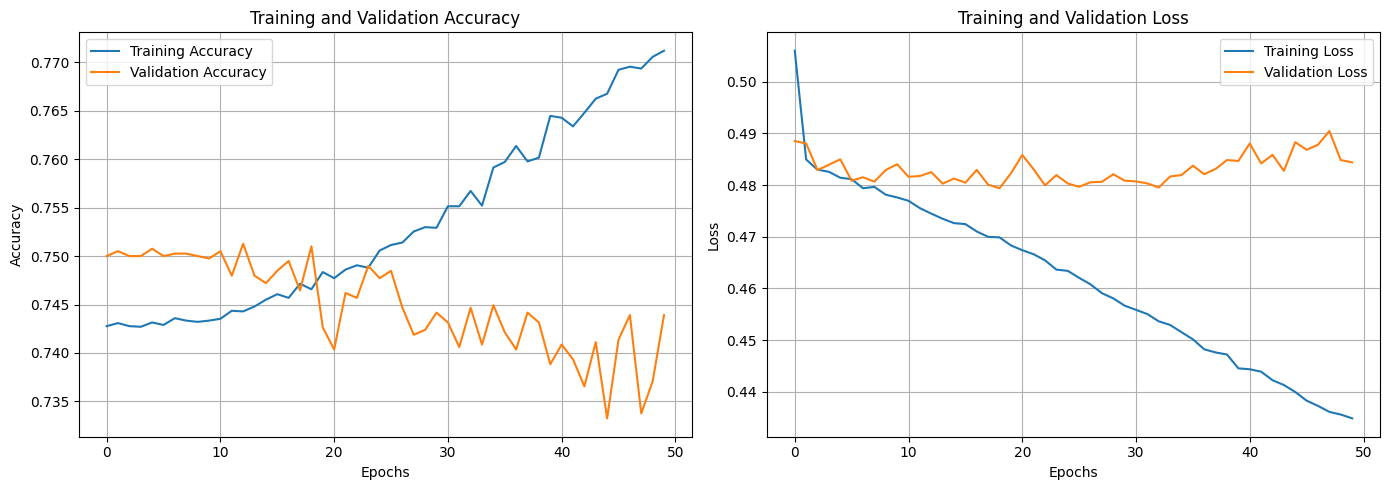

In [948]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid()

# Plot Loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Training and Validation Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid()

# Show the plots
plt.tight_layout()
plt.show()